In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
sns.set_context("poster")
sns.set_style('ticks')

# Empirical Data

In [2]:
cues = pd.read_csv('how_many_cues.csv', sep=';')
stim = pd.read_csv('input_stimuli.csv',sep=';')
choices = pd.read_csv('choices.csv', sep=';')
weights = np.array([0.706, 0.688, 0.667, 0.647, 0.625, 0.6]) # validity of cues (from experiment)

def read_values(trial):
    stim = pd.read_csv('input_stimuli.csv', sep=';')
    trdata = list(stim[['c1','c2','c3','c4','c5','c6','c1.1','c2.1','c3.1','c4.1','c5.1','c6.1']].loc[trial])
    A = trdata[:len(trdata)//2]
    B = trdata[len(trdata)//2:]
    return np.array([[A[n], B[n]] for n in range(len(A))])

def read_RT_empirical(participant, trial):
    cols = list(cues.columns)
    return list(cues[cols[participant+1]])[trial]

def read_choice(participant, trial):
    cols = list(choices.columns)
    return list(choices[cols[participant+1]])[trial]

def get_correct(values, weights):
    evidence_A = np.dot(values[:,0], weights)
    evidence_B = np.dot(values[:,1], weights)
    return np.argmax([evidence_A, evidence_B])

def get_accuracy_empirical(choice, trial):
    values = read_values(trial)
    correct = get_correct(values, weights)
    if choice == 'A' and correct == 0:
        return True
    if choice == 'B' and correct == 1:
        return True
    return False

def mean_RTs_accuracies():
    columns = ('trial', 'participant', 'accuracy', 'RT')
    df = pd.DataFrame(columns=columns)
    mean_RTs = np.zeros((14))
    mean_accuracies = np.zeros((14))
    n_partitipants =  14
    n_trials = 48
    for participant in range(n_partitipants):
        accuracies_participant = []
        RTs_participant = []
        for trial in range(n_trials):
            accuracy = get_accuracy_empirical(read_choice(participant, trial), trial)
            RT = read_RT_empirical(participant, trial)
            accuracies_participant.append(accuracy)
            RTs_participant.append(RT)
            df = df.append(pd.DataFrame([[participant, trial, accuracy, RT]], columns=columns), ignore_index=True)
        mean_RTs[participant] = np.mean(RTs_participant)
        mean_accuracies[participant] = np.mean(accuracies_participant)

        if participant == 0:
            RTs_human_fast = RTs_participant
            accuracies_human_fast = 100*np.mean(accuracies_participant)
        if participant == 12:
            RTs_human_slow = RTs_participant
            accuracies_human_slow = 100*np.mean(accuracies_participant)
            
    return mean_RTs, mean_accuracies

def individual_RTs_accuracies():
    n_partitipants =  14
    n_trials = 48
    for participant in range(n_partitipants):
        accuracies_participant = []
        RTs_participant = []
        for trial in range(n_trials):
            accuracy = get_accuracy_empirical(read_choice(participant, trial), trial)
            RT = read_RT_empirical(participant, trial)
            accuracies_participant.append(accuracy)
            RTs_participant.append(RT)
        if participant == 0:
            RTs_human_fast = RTs_participant
            accuracies_human_fast = 100*np.mean(accuracies_participant)
        if participant == 12:
            RTs_human_slow = RTs_participant
            accuracies_human_slow = 100*np.mean(accuracies_participant)
            
    return RTs_human_fast, accuracies_human_fast, RTs_human_slow, accuracies_human_slow

In [3]:
mean_RTs_human, mean_accuracies_human = mean_RTs_accuracies()
RTs_human_fast, accuracies_human_fast, RTs_human_slow, accuracies_human_slow = individual_RTs_accuracies()

# Model data

In [4]:
n_agents = 28
data = [np.load("data/%s.npz"%(n+1)) for n in range(n_agents)]
mean_RTs_agent = np.array([np.mean(D['RTs']) for D in data])
mean_accuracies_agent = np.array([np.mean(D['accuracies']) for D in data])

agent_fast = 107  # 107 best
agent_slow = 109  # 109 best
RTs_agent_fast = np.load("data/%s.npz"%agent_fast)['RTs']
accuracies_agent_fast = 100*np.mean(np.load("data/%s.npz"%agent_fast)['accuracies'])
RTs_agent_slow = np.load("data/%s.npz"%agent_slow)['RTs']
accuracies_agent_slow = 100*np.mean(np.load("data/%s.npz"%agent_slow)['accuracies'])

# Plot RT distribution

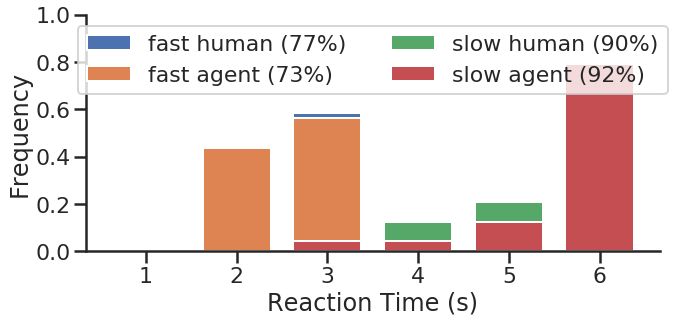

In [13]:
fig, ax = plt.subplots(1, 1, figsize=((10, 5)), sharex=True)
ax.hist(RTs_human_fast, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=0.75, density=True, label='fast human (%.0f%%)'%accuracies_human_fast)
ax.hist(RTs_agent_fast, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=0.75, density=True, label='fast agent (%.0f%%)'%accuracies_agent_fast)
ax.hist(RTs_human_slow, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=0.75, density=True, label='slow human (%.0f%%)'%accuracies_human_slow)
ax.hist(RTs_agent_slow, bins=np.array([1,2,3,4,5,6,7])-0.5, rwidth=0.75, density=True, label='slow agent (%.0f%%)'%accuracies_agent_slow)
ax.set(xlabel='Reaction Time (s)', ylabel="Frequency", xticks=([1,2,3,4,5,6]), ylim=((0, 1.0)))
ax.legend(loc='upper center', ncol=2)
plt.tight_layout()
sns.despine()
plt.savefig("plots/RTs.svg")
plt.savefig("plots/RTs.pdf")
plt.savefig("plots/RTs.png")

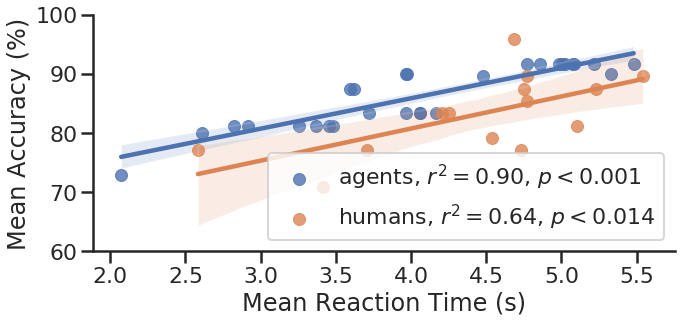

In [16]:
agent_r2, agent_p = scipy.stats.linregress(mean_RTs_agent, mean_accuracies_agent)[2:4]
human_r2, human_p = scipy.stats.linregress(mean_RTs_human, mean_accuracies_human)[2:4]
agent_p = np.max([agent_p, 1e-3])
human_p = np.max([human_p, 1e-3])

fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(mean_RTs_agent, 100*mean_accuracies_agent, label=r"agents, $r^2=%.2f$, $p<%.3f$"%(agent_r2, agent_p))
sns.regplot(mean_RTs_human, 100*mean_accuracies_human, label=r"humans, $r^2=%.2f$, $p<%.3f$"%(human_r2, human_p))
ax.set(xlabel='Mean Reaction Time (s)', ylabel='Mean Accuracy (%)', ylim=((60, 100)))
ax.legend()
plt.tight_layout()
sns.despine()
plt.savefig("plots/SAT.svg")
plt.savefig("plots/SAT.pdf")
plt.savefig("plots/SAT.png")